# TPS-Feb-2022

In [1]:
NB = '107'
dataset_NB = '002'

## Import libralies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import mode
import time

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping

## Load and check data

In [3]:
# Load data
##### Load train and Test set
train = pd.read_pickle(f"../data/processed/nb{dataset_NB}_train.pkl", compression='zip')
test = pd.read_pickle(f"../data/processed/nb{dataset_NB}_test.pkl", compression='zip')

submission = pd.read_csv('../data/raw/sample_submission.csv')

In [4]:
train_len = len(train)
test_id = test['row_id']

#dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
# reset_index: indexを0から順に振り直す
# drop: Falseの場合、元のindexが「index」列が新たに生成されて残る。Trueの場合「index」列は作られない。

#dataset = dataset.drop(columns=['row_id'])
#train = train.drop(columns=['row_id'])

#dataset.head()

## Parameter Setting

In [5]:
RANDOM_STATE = 13
FOLDS = 4
TARGET = 'target'
FEATURES = [col for col in train.columns if col not in ['row_id', TARGET]]

FEATURES

['A0T0G0C10',
 'A0T0G1C9',
 'A0T0G2C8',
 'A0T0G3C7',
 'A0T0G4C6',
 'A0T0G5C5',
 'A0T0G6C4',
 'A0T0G7C3',
 'A0T0G8C2',
 'A0T0G9C1',
 'A0T0G10C0',
 'A0T1G0C9',
 'A0T1G1C8',
 'A0T1G2C7',
 'A0T1G3C6',
 'A0T1G4C5',
 'A0T1G5C4',
 'A0T1G6C3',
 'A0T1G7C2',
 'A0T1G8C1',
 'A0T1G9C0',
 'A0T2G0C8',
 'A0T2G1C7',
 'A0T2G2C6',
 'A0T2G3C5',
 'A0T2G4C4',
 'A0T2G5C3',
 'A0T2G6C2',
 'A0T2G7C1',
 'A0T2G8C0',
 'A0T3G0C7',
 'A0T3G1C6',
 'A0T3G2C5',
 'A0T3G3C4',
 'A0T3G4C3',
 'A0T3G5C2',
 'A0T3G6C1',
 'A0T3G7C0',
 'A0T4G0C6',
 'A0T4G1C5',
 'A0T4G2C4',
 'A0T4G3C3',
 'A0T4G4C2',
 'A0T4G5C1',
 'A0T4G6C0',
 'A0T5G0C5',
 'A0T5G1C4',
 'A0T5G2C3',
 'A0T5G3C2',
 'A0T5G4C1',
 'A0T5G5C0',
 'A0T6G0C4',
 'A0T6G1C3',
 'A0T6G2C2',
 'A0T6G3C1',
 'A0T6G4C0',
 'A0T7G0C3',
 'A0T7G1C2',
 'A0T7G2C1',
 'A0T7G3C0',
 'A0T8G0C2',
 'A0T8G1C1',
 'A0T8G2C0',
 'A0T9G0C1',
 'A0T9G1C0',
 'A0T10G0C0',
 'A1T0G0C9',
 'A1T0G1C8',
 'A1T0G2C7',
 'A1T0G3C6',
 'A1T0G4C5',
 'A1T0G5C4',
 'A1T0G6C3',
 'A1T0G7C2',
 'A1T0G8C1',
 'A1T0G9C0',
 'A1T1G0C

## Modeling

### 目的変数（target）を数値に変換する

In [6]:
encoder = LabelEncoder()
train[TARGET] = encoder.fit_transform(train[TARGET])

In [7]:
train.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,gcd,mean,std,min,max,median,25%,75%,skew,kurt
0,0,0,0,0,0,0,0,0,0,0,...,10000,3496.503497,7422.936598,0,40000,0.0,0.00,0.0,2.393523,5.856459
1,1,0,0,0,1000,0,1000,0,0,0,...,1000,3496.503497,5211.827475,0,26000,1000.0,0.00,4750.0,2.242743,5.173521
2,2,0,8,50,243,468,510,443,239,44,...,1,3496.503497,4899.271608,0,24155,1340.0,321.50,4402.5,2.086805,4.169623
3,3,1,4,55,359,692,762,596,311,40,...,1,3496.503497,4763.599809,0,24472,1445.5,390.25,4583.5,2.016652,3.827831
4,4,0,0,0,0,0,0,0,0,0,...,10000,3496.503497,8101.006328,0,50000,0.0,0.00,0.0,3.147624,12.195877


In [8]:
train.shape

(123993, 298)

### ExtraTreeClassifier

In [9]:
predictions, scores = [], []

k = StratifiedKFold(n_splits = FOLDS, random_state = RANDOM_STATE, shuffle = True)
for i, (train_idx, val_idx) in enumerate(k.split(train[FEATURES], train[TARGET])):

    X_train, X_val = train.iloc[train_idx][FEATURES], train.iloc[val_idx][FEATURES]
    y_train, y_val = train[TARGET].iloc[train_idx] , train[TARGET].iloc[val_idx]

    model = ExtraTreesClassifier(n_estimators=1111, n_jobs=-1)
    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    val_score = accuracy_score(y_val, val_pred)
    print(f'Fold {i+1} accuracy score: {round(val_score, 4)}')

    scores.append(val_score)
    predictions.append(model.predict_proba(test[FEATURES]))

print('')
print(f'Mean accuracy - {round(np.mean(scores), 4)}')

Fold 1 accuracy score: 0.9743
Fold 2 accuracy score: 0.976
Fold 3 accuracy score: 0.9765
Fold 4 accuracy score: 0.9748

Mean accuracy - 0.9754


In [10]:
y_proba = sum(predictions) / len(predictions)
y_proba += np.array([0, 0, 0.025, 0.045, 0, 0, 0, 0, 0, 0])
y_pred_tuned = encoder.inverse_transform(np.argmax(y_proba, axis=1))

extratree_submission = submission.copy()
extratree_submission[TARGET] = y_pred_tuned

extratree_submission.to_csv(f"../data/submission/nb{NB}_ExtraTree.csv",index=False)
extratree_submission.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


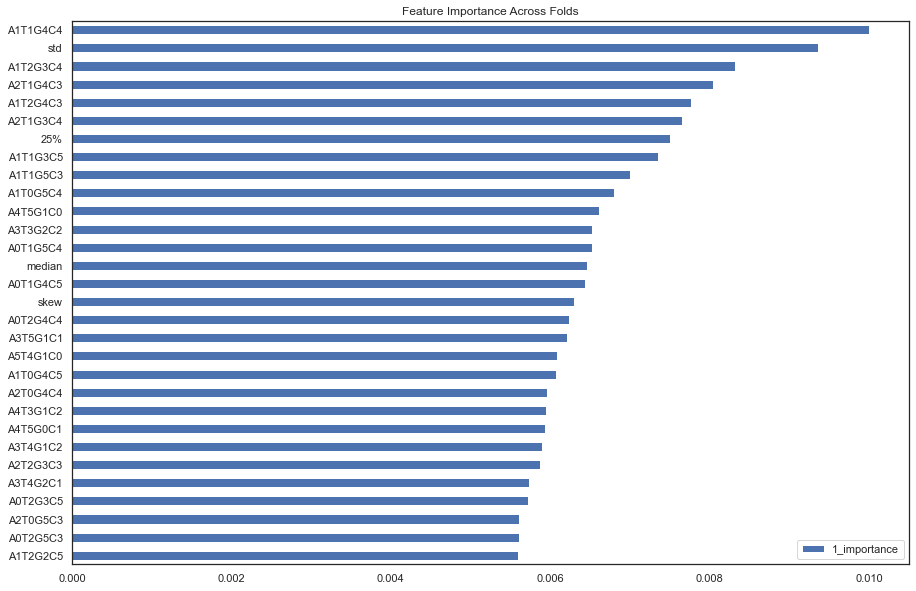

In [29]:
### feature importance
feat_imp = pd.DataFrame(index=FEATURES, data=model.feature_importances_, columns=[f'1_importance'])
#lgbm_fis_df = feat_imp.head(100)
feat_imp.sort_values('1_importance').tail(30).plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

In [28]:
feat_imp.sort_values('1_importance').head(30)

,1_importance
mean,0.000000
A0T0G0C10,0.000585
A0T2G0C8,0.000641
A0T2G8C0,0.000675
A0T0G9C1,0.000688
A2T0G0C8,0.000741
A1T0G8C1,0.000754
A0T3G0C7,0.000793
A3T0G7C0,0.000825
A0T3G7C0,0.000825


In [30]:
feat_imp.sort_values('1_importance').tail(30)

,1_importance
A1T2G2C5,0.005602
A0T2G5C3,0.005610
A2T0G5C3,0.005611
A0T2G3C5,0.005727
A3T4G2C1,0.005729
A2T2G3C3,0.005872
A3T4G1C2,0.005900
A4T5G0C1,0.005929
A4T3G1C2,0.005945
A2T0G4C4,0.005958


### LightGBM

In [ ]:
lgb_fixed_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    "n_estimators": 3000,
    'learning_rate': 0.1,
}

#fit_params = {"early_stopping_rounds": 100,
#            "eval_set": [[X_test, y_test]]}


# LightGBM parameters
lgb_param_grid = {
                 #'learning_rate': [0.1, 0.05],
                 'num_leaves' : [63],
                 #'num_leaves' : [12, 15, 18],
                 'max_depth'  : [21],
                 #'max_depth'  : [6, 9, 15],
                 #'min_gain_to_split' : [0, 0.1, 0.2],
                 #'feature_fraction' : [0.5, 0.7, 1],
                 #'bagging_fraction' : [0.7, 0.9, 1],
                 #'min_sum_hessian_in_leaf' : [1, 2, 4],
                }

callbacks = [early_stopping(50)]

In [ ]:
lgb_predictions = []
lgb_scores = []
lgb_feature_importance = []
lgb_result = {}

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(train[FEATURES], train[TARGET])):

    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()

    ### データセット作成
    X_train, X_val = train.iloc[train_idx][FEATURES], train.iloc[val_idx][FEATURES]
    y_train, y_val = train[TARGET].iloc[train_idx] , train[TARGET].iloc[val_idx]

    ### 学習
    lgb_model = LGBMClassifier(**lgb_fixed_params)

    # gs = GridSearchCV(model, param_grid=lgb_param_grid, fit_params=lgb_fixed_params, cv=FOLDS, n_jobs=-1, verbose=2)
    gs_lgb = GridSearchCV(lgb_model, param_grid=lgb_param_grid, cv=FOLDS, n_jobs=-1, verbose=2)
    gs_lgb.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, callbacks=callbacks)

    #model.fit(X_train, y_train,verbose=0)
    #model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, callbacks=callbacks)

    ### 結果格納
    lgb_result[f'Fold{fold}_best_estimator'] = gs_lgb.best_estimator_
    lgb_result[f'Fold{fold}_best_score'] = gs_lgb.best_score_
    lgb_result[f'Fold{fold}_best_grid_params'] = gs_lgb.best_params_
    lgb_result[f'Fold{fold}_best_all_params'] = lgb_result[f'Fold{fold}_best_estimator'].get_params()
    lgb_result[f'Fold{fold}_cv_result'] = pd.DataFrame(gs_lgb.cv_results_)

    ### Best Score
    print(f"Best Score: {gs_lgb.best_score_}")
    print(f"Best Param: {gs_lgb.best_params_}")

    ### 推論（validation）
    preds_val = gs_lgb.predict(X_val)
    acc = accuracy_score(y_val, preds_val)
    lgb_scores.append(acc)

    ### 結果格納
    lgb_result[f'Fold{fold}_preds_val'] = preds_val
    lgb_result[f'Fold{fold}_y_val'] = y_val
    lgb_result[f'Fold{fold}_acc'] = acc

    ### feature importance
    feat_imp = pd.DataFrame(index=FEATURES, data=lgb_result[f'Fold{fold}_best_estimator'].feature_importances_, columns=[f'{fold}_importance'])
    lgb_feature_importance.append(feat_imp)

    ### 推論（test）
    test_preds = gs_lgb.predict(test[FEATURES])
    lgb_predictions.append(test_preds)

    ### 結果表示
    run_time = time.time() - start_time
    print(f"Fold={fold+1}, Accuracy: {acc:.5f}, Run Time: {run_time:.2f}s")

print(10*"=", "Cross Validation finished.", 10*"=")
print("Mean Accuracy :", np.mean(lgb_scores))
print(lgb_result)

In [ ]:
for fold in range(FOLDS):
    plt.figure(figsize=(15,10))
    cm = confusion_matrix(lgb_result[f'Fold{fold}_y_val'], lgb_result[f'Fold{fold}_preds_val'])
    display(accuracy_score(lgb_result[f'Fold{fold}_y_val'], lgb_result[f'Fold{fold}_preds_val']))
    sns.heatmap(cm, annot=True, cmap='Blues')


### feature importances

In [ ]:
lgbm_fis_df = pd.concat(lgb_feature_importance, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

## Submission

In [ ]:
lgb_submission = submission.copy()
lgb_submission[TARGET] = encoder.inverse_transform(np.squeeze(mode(np.column_stack(lgb_predictions),axis = 1)[0]).astype('int'))
#lgb_submission[TARGET] = np.squeeze(mode(np.column_stack(lgb_predictions),axis = 1)[0]).astype('int')
### 列方向にリストを行列化して、各行の最頻値をとって、１次元の配列は削除して、intにして、数値をラベルに戻している

lgb_submission.to_csv(f"../data/submission/nb{NB}_LGBM.csv",index=False)
lgb_submission.head()

## 検証メモ

In [ ]:
fit_params = {"early_stopping_rounds": 100,
              "eval_set": [[X_test, y_test]]}

xgb_model = xgb.XGBClassifier()
gs = GridSearchCV(xgb_model,
                  params,
                  fit_params=fit_params,
                  cv=10,
                  n_jobs=-1,
                  verbose=2)
gs.fit(X_train, y_train)

In [ ]:
from copy import deepcopy
from itertools import product
from collections import defaultdict

def GridSearchCV_XGB_early_stoppping(param_grid, param_fixed, scorer, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        param_fixed (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (DataFrame): The input data matrix.
        y (Series): The ground truth label.

    Returns:
        dict: The best set of parameters found via grid search.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        gscv_x_train, gscv_x_val = X[train_index], X[test_index]
        gscv_y_train, gscv_y_val = y[train_index], y[test_index]

        param_fixed_cv = deepcopy(param_fixed)
        param_fixed_cv['eval_set'] = [(gscv_x_val, gscv_y_val)]

        for value_combination in product(*param_values):
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBRegressor(**dict(param_grid_cv))

            xgboost.fit(gscv_x_train, gscv_y_train, **param_fixed_cv)
            if 'early_stopping_rounds' not in param_fixed_cv:
                best_iteration = xgboost.get_num_boosting_rounds()
            else:
                best_iteration = xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, gscv_x_val, gscv_y_val)
            cv_results[param_grid_cv].append(score)

    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))

    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))

    return best_params_xgb